In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import LeakyReLU

import keras_tuner
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping, Callback

!pip install shap
import shap
import pickle
import copy

import seaborn as sns; sns.set_theme()
from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib as mlp

import lime
import lime.lime_tabular

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [3]:
inp = pd.read_csv("/kaggle/input/a1101-data/A1101.csv", header = 0, low_memory=False, sep=",")
inp.index = range(len(inp))
inp.head()

inp = inp.groupby('sequence', as_index=False).mean()
inp

,sequence,intensity
0,AAAATSAGTR,0.253411
1,AAASSLLYK,0.748583
2,AAATSAGTR,0.231444
3,AAATSAGTRR,0.341356
4,AAAYFVGYLK,1.000000
...,...,...
6278,YYKDDISYF,0.084687
6279,YYLEKANKI,0.084687
6280,YYPEDPVKL,0.084687
6281,YYQLCQHLK,0.469617


In [4]:
#Tạo list các axit amin để encoding
peptides = inp['sequence'].tolist()
peptides.sort()
vocab = set(''.join([str(i) for i in peptides]))
vocab.add('END')
vocab_list = list(vocab)
vocab_list.sort()
#vocab_list

#Thêm END vào các peptides dài 8-9 có độ dài 10 
char_index = dict((vocab_list[i], i) for i in range(len(vocab_list)))
X = []
x_name = [str(i)[0:10] for i in peptides]
for i in x_name:
    tmp = [char_index[j] for j in str(i)]
    for k in range(0,10 - len(str(i))):
        tmp.append(char_index["END"])
    X.append(tmp)
#X

#Tạo list chứa toàn bộ giá trị CCS
Y = []
for index, row in inp.iterrows():
    my_list = [row.intensity]
    Y.append(my_list)
#all_int_list[0]

X = np.asarray(X)
Y = np.asarray(Y)

In [5]:
#Chia thành tập train, test, val
x_train_all, x_test, y_train_all, y_test = train_test_split(X,Y, test_size=0.1, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, test_size=0.2, random_state=42)

In [ ]:
np.savetxt('CCS_x_test.txt', x_test)
np.savetxt('CCS_y_test.txt', y_test)
np.savetxt('CCS_x_train.txt', x_train)
np.savetxt('CCS_y_train.txt', y_train)
np.savetxt('CCS_x_val.txt', x_val)
np.savetxt('CCS_y_val.txt', y_val)

In [3]:
x_train = np.loadtxt('/kaggle/input/a1101-data/A1101_x_train.txt')

x_test = np.loadtxt('/kaggle/input/a1101-data/A1101_x_test.txt')

y_train = np.loadtxt('/kaggle/input/a1101-data/A1101_y_train.txt')

y_test = np.loadtxt('/kaggle/input/a1101-data/A1101_y_test.txt')

x_val = np.loadtxt('/kaggle/input/a1101-data/A1101_x_val.txt')

y_val = np.loadtxt('/kaggle/input/a1101-data/A1101_y_val.txt')

In [14]:
%%time

#Model LSTM 
model = Sequential()
model.add(Embedding(output_dim = 50, input_dim = 21, input_length = 10))

model.add(LSTM(128,return_sequences=True, input_shape=(10,21)))
model.add(Dropout(0.53))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.56))

model.add(Dense(64))
model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.8))

model.add(Dense(1))

optimizermodel = tf.keras.optimizers.Adam(0.001)
optimizermodel.learning_rate.assign(0.01)
model.compile(loss='mse', optimizer = optimizermodel, metrics=['mse'])

hist = model.fit(x_train, y_train,
                batch_size = 5000,
                epochs = 200,
                validation_data = (x_val, y_val))



Epoch 1/200


Argument `input_length` is deprecated. Just remove it.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
Argument `alpha` is deprecated. Use `negative_slope` instead.


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.1810 - mse: 0.1810 - val_loss: 0.0915 - val_mse: 0.0915
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.1323 - mse: 0.1323 - val_loss: 0.3662 - val_mse: 0.3662
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.4244 - mse: 0.4244 - val_loss: 0.2798 - val_mse: 0.2798
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.4669 - mse: 0.4669 - val_loss: 0.4410 - val_mse: 0.4410
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.5203 - mse: 0.5203 - val_loss: 0.0916 - val_mse: 0.0916
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1352 - mse: 0.1352 - val_loss: 0.0895 - val_mse: 0.0895
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.1118 - mse: 0.1118 - val_loss: 0.1055 - val_mse: 0.1055
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.1179 - mse: 0.1179 - val_loss: 0.0986 - val_mse: 0.0986
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.1200 - mse: 0.1200 - val_l

In [15]:
y_pred = model.predict(x_test)
model_r2 = r2_score(y_test, y_pred)
model_mae = mean_absolute_error(y_test, y_pred)
model_mse = mean_squared_error(y_test, y_pred)
print(model_r2, model_mae, model_mse)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
0.6754086551470957 0.13138519454860642 0.02938757298461587


In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(Embedding(output_dim=50, input_dim=21, input_length=10))

    model.add(GRU(hp.Int('units_1', min_value=32, max_value=128, step=32),
                  return_sequences=True, input_shape=(10, 21)))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.8)))

    model.add(GRU(hp.Int('units_2', min_value=32, max_value=128, step=32)))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.0, max_value=0.8)))

    model.add(Dense(1))

    learning_rate = hp.Choice('learning_rate', values=[0.001, 0.005, 0.01, 0.05])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(loss='mse', optimizer=optimizer, metrics=['mse'])

    return model

tuner = RandomSearch(
    build_model,
    objective='val_mse',
    max_trials=30,  
    executions_per_trial=1,  
    directory='tuner_results',
    project_name='gru_model_tuning_9'
)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

tuner.search(x_train, y_train,
             epochs=200,
             batch_size=tuner.oracle.hyperparameters.Choice('batch_size', values=[64, 128, 256, 512]),
             validation_data=(x_val, y_val),
             callbacks=[early_stopping],
             verbose=1)

best_model = tuner.get_best_models(num_models=1)[0]
best_run = tuner.oracle.get_best_trials(num_trials=1)[0]

best_model.summary()
print(best_run.hyperparameters.values)


In [24]:
%%time

#model GRU
model1 = Sequential()
model1.add(Embedding(output_dim = 50, input_dim = 21, input_length = 10))

model1.add(GRU(128, return_sequences=True))
model1.add(Dropout(0.28))

model1.add(GRU(128))
model1.add(Dropout(0.18))

model1.add(Dense(1))

optimizer = tf.keras.optimizers.Adam(0.001)

model1.compile(loss='mse', optimizer=optimizer)
model1.fit(x_train, y_train, 
           epochs = 100, 
           batch_size = 512, 
           validation_data = (x_val, y_val))

Epoch 1/100


Argument `input_length` is deprecated. Just remove it.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.1272 - val_loss: 0.0736
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0743 - val_loss: 0.0603
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0597 - val_loss: 0.0499
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0552 - val_loss: 0.0476
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0507 - val_loss: 0.0470
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0501 - val_loss: 0.0450
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0485 - val_loss: 0.0442
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0479 - val_loss: 0.0436
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0453 - val_loss: 0.0434
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0468 - val_loss: 0.0421
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0445 - val_loss: 0.0410
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0422 - val_loss: 0.0405
E

In [25]:
y_pred1 = model1.predict(x_test)
model1_r2 = r2_score(y_test, y_pred1)
model1_mae = mean_absolute_error(y_test, y_pred1)
model1_mse = mean_squared_error(y_test, y_pred1)
print(model1_r2, model1_mae, model1_mse)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
0.6658316378296802 0.12737521174366226 0.030254648770379713


In [10]:
#Chọn model
model = model1
x_test=x_test[:5]
print(x_test)

[[ 9 17 14  3 13 13 14 18  0  4]
 [12  5 13 14  7 18  8 17  9  4]
 [ 9 14 20 12 18 17 14  0  5  4]
 [18  5  2 16  9 10  8 16  3  9]
 [10 16 18  8 19 11 11 19 20 19]]


**SHAP**

In [11]:
%%time

#Tạo 100 cụm dữ liệu để tính toán SHAP
x_trainmeans = shap.kmeans(np.asarray(x_train), 100)
explainer = shap.KernelExplainer(model.predict, x_trainmeans)
shap_values = explainer.shap_values(np.asarray(x_test))

#lưu giá trị SHAP
with open("A1101_shapvalues_GRU.pkl","wb") as f:
    pickle.dump(shap_values, f)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3194/3194 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3194/3194 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3194/3194 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3194/3194 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3194/3194 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
CPU times: user 54.1 s, sys: 8 s, total: 1min 2s
Wall time: 38.5 s


In [21]:
with open("/kaggle/input/a1101-data/shapvaluesA1101.pkl","rb") as f:
    shap_values = pickle.load(f)



0.03799275171633592


**LIME**

In [39]:
%%time

#Định nghĩa hàm giải thích LIME
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data = x_train,
    mode = 'regression',
    feature_names = [f'Pos{i+1}' for i in range(10)],
)
positions = [f'Pos{i+1}' for i in range(10)]

lime_values = []
for i in range(len(x_test)):
    x_instance = x_test[i]
    ordered_contributions = {pos: 0.0 for pos in positions}

    #Tính LIME cho từng instance
    exp = explainer.explain_instance(
        data_row = x_instance,
        predict_fn = model.predict
    )

    for feature_value, contribution in exp.as_list():
        pos = next((word for word in feature_value.split() if word.startswith('Pos')), None)
        if pos in ordered_contributions:
            ordered_contributions[pos] += contribution

    contributions_sorted = [ordered_contributions[pos] for pos in positions]
    lime_values.append(contributions_sorted)

with open('A1101_lime_values_LSTM.pkl', 'wb') as f:
    pickle.dump(lime_values, f)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
CPU times: user 3.75 s, sys: 1.6 s, total: 5.35 s
Wall time: 2.51 s


In [14]:
with open('/kaggle/input/a1101-data/A1101_lime_values_LSTM.pkl', 'rb') as f:
    lime_values = pickle.load(f)

**OSA**

In [42]:
%%time

#Tính OSA
baseline = 0
original_output = model.predict(x_test).flatten()
osa_values = np.zeros_like(x_test, dtype=np.float32)

for i in range(10):
    osa_inputs = x_test.copy()
    osa_inputs[:,i] = baseline
    osa_output = model.predict(osa_inputs).flatten()

    osa_values[:,i] = np.abs(original_output - osa_output)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
CPU times: user 565 ms, sys: 33.6 ms, total: 599 ms
Wall time: 573 ms


**HEATMAP**

In [40]:
#Tạo mảng lưu các giá trị SHAP/LIME/OSA của 1 axit amin ở cùng 1 vị trí (pos=[1,10])

#Chọn giá trị
explain_values = osa_values

aa = []
i = 0
while i < 10:
    aa.append([[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0]])
    i+=1

i=0
while i < len(x_test):
    j = 0
    while j < len(x_test[i]):
        aa[j][int(x_test[i][j])].append(explain_values[i][j])
        j+=1
    i+=1

heatmap = []

i = 0
while i < len(aa):
    j = 0
    heatmap.append([])
    while j < len(aa[i]):
        if len(aa[i][j]) > 1:
            aa[i][j] = aa[i][j][1:]
            heatmap[i].append(sum(aa[i][j])/float(len(aa[i][j])))
        else:
            heatmap[i].append(0)
        j+=1
    i+=1
heatmap = np.array(heatmap)

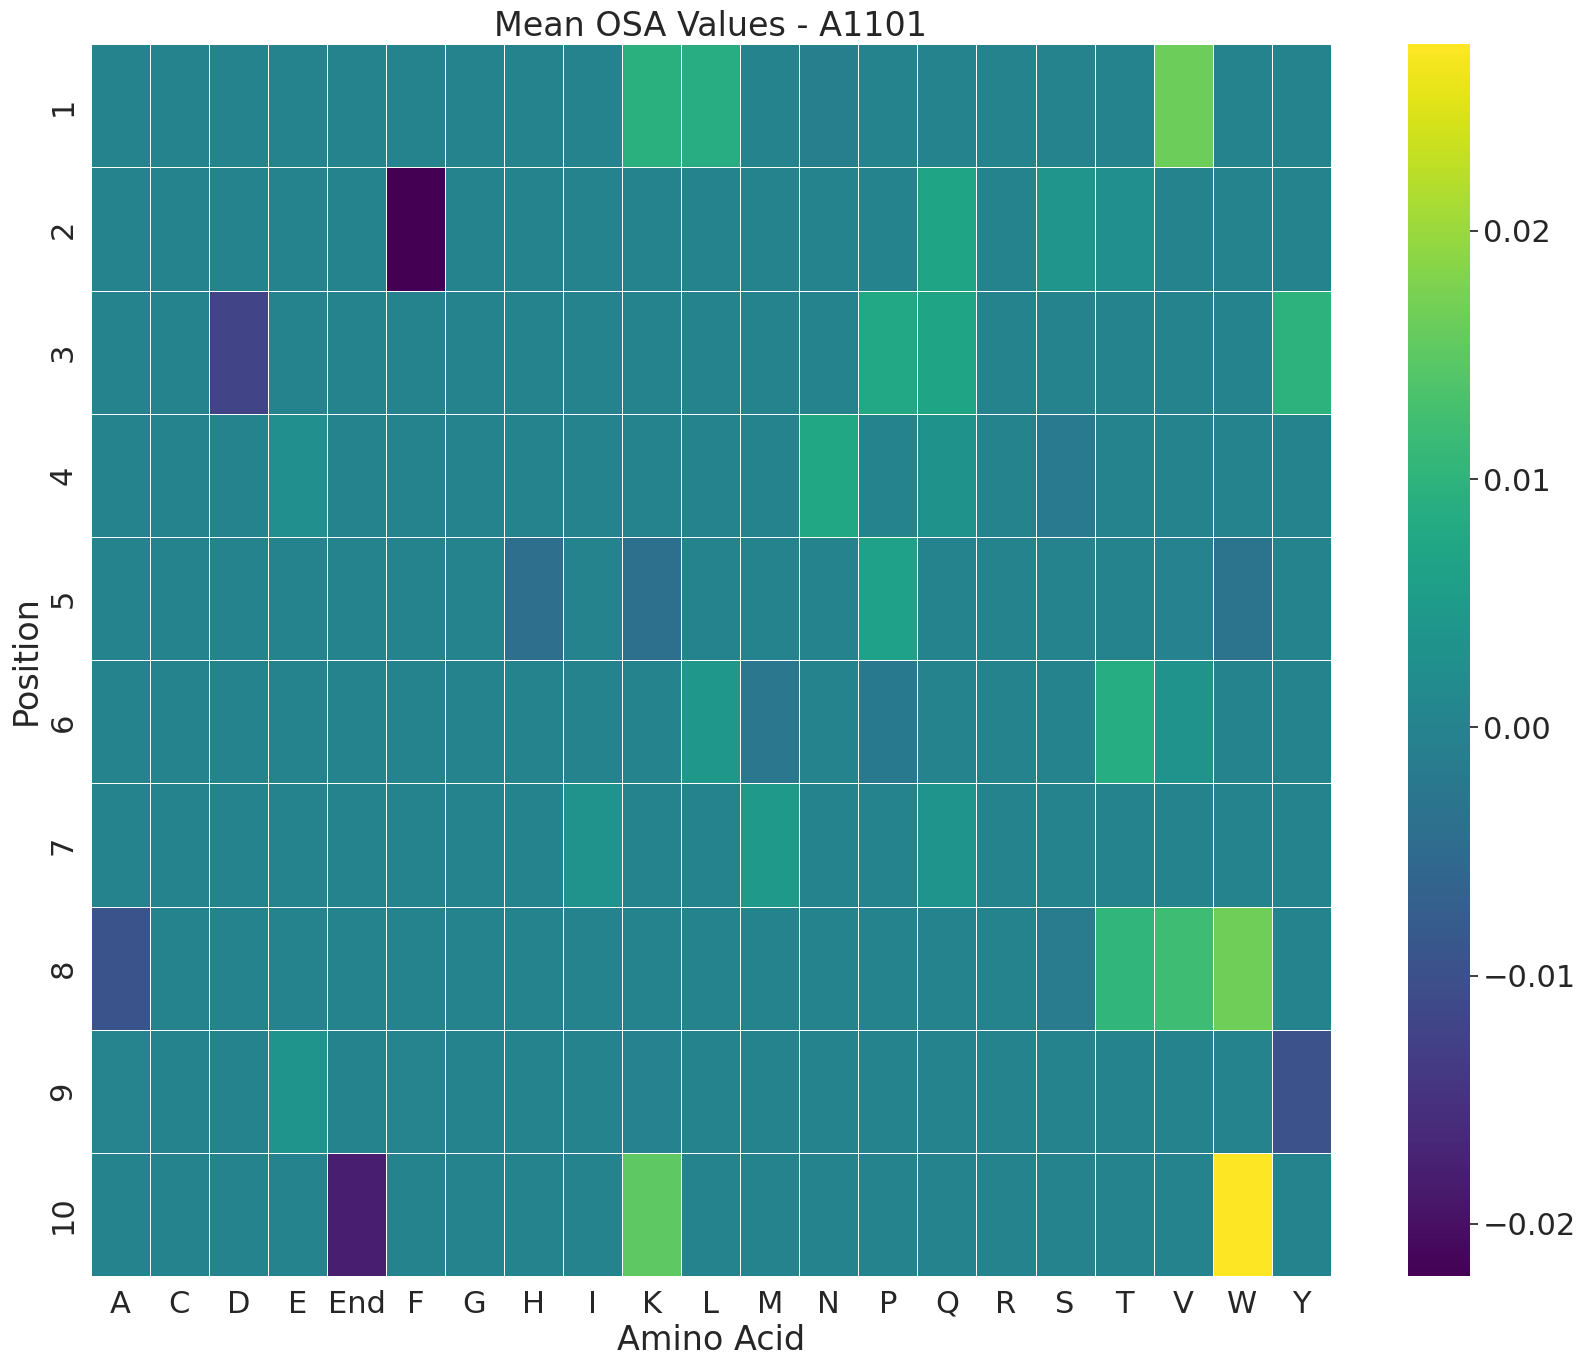

In [43]:
plt.figure()
x_axis_labels = ['A','C','D','E','End','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y'] # labels for x-axis
y_axis_labels = ['1','2','3','4','5','6','7','8','9','10']
sns.set(font_scale = 2)

rcParams['figure.figsize'] = 20,16
ax = sns.heatmap(heatmap,xticklabels=x_axis_labels, yticklabels=y_axis_labels,linewidths=.5,  cmap="viridis")

ax.set(xlabel='Amino Acid', ylabel='Position', title='Mean OSA Values - A1101')
ax.figure.savefig('A1101.png')
plt.show()